In [1]:
using SerialPorts
using PyPlot
using FFTW

In [20]:
c = 343;          # Speed of sound in air in m/s
fs = 500000;       # This is the sample rate of the sonar.
dt = 1/fs;        # This is the sample spacing
r_max = 12;        # Maximum range in metres to which to simulate.
t_max = 2*r_max/c;

t = collect(0:dt:t_max);
print(length(t))

# t = t[0:length(y)]
r = c*t/2;

f0 = 40000;       # Centre frequency is 40 kHz
B = 2000;         # Chirp bandwidth
T = 6E-3;         # Chirp pulse length
K = B/T;          # Chirp rate
N = length(t)

34986

34986

In [21]:
# Define a simple a rect() function which returns for -0.5<=t<=0.5 or 0. 
# The function will work if t is an array of values.
rect(t) = (abs.(t) .<= 0.5)*1.0

# rect(t/T) spans the interval [-T/2,T/2]
# We must therefore delay the chirp pulse so that it starts after t=0.
# Shift the chirp pulse by 0.6T units to the right, so that it starts at 0.1*T

td = 0.6*T;   # Chirp delay

# Note: one can use the macro “@.” to avoid having to put “.” for arrays:
# @. v_tx = cos( 2*pi*(f0*(t-td) + 0.5*K*(t-td).^2) ).*rect((t-td)/T);

v_tx = cos.( 2*pi*(f0*(t .- td) + 0.5*K*(t .- td).^2) ) .* rect.((t .-td)/T);

v_tx = v_tx[1:30000]
println(length(v_tx));

30000


In [22]:
matched_one = open("Filter1.txt") do file
    read(file, String)
end

matched_two = open("Filter2.txt") do file
    read(file, String)
end

array_one=split(matched_one, (", "))

array_two = split(matched_two, (", "))

#=================================================================#
ma1 = []
ma2 = []

for i in array_one
    if (i == "")
        continue
    end
    push!(ma1,parse(Int,i))
end

for i in array_two
    if (i == "")
        continue
    end
    push!(ma2,parse(Int,i))
end

MatchOne = (3.3/4096).*ma1
MatchTwo = (3.3/4096).*ma2


30000-element Array{Float64,1}:
 1.2536132812499998
 1.2576416015624998
 1.2568359375      
 1.2495849609374998
 1.248779296875    
 1.2495849609374998
 1.2592529296875   
 1.2528076171875   
 1.2576416015624998
 1.2584472656249999
 1.2528076171875   
 1.2528076171875   
 1.2528076171875   
 ⋮                 
 1.252001953125    
 1.2528076171875   
 1.2528076171875   
 1.2528076171875   
 1.2528076171875   
 1.2528076171875   
 1.2503906249999999
 1.2528076171875   
 1.255224609375    
 1.2536132812499998
 1.252001953125    
 1.2528076171875   

In [23]:
for i = 0:4985
    push!(MatchOne,0)
    push!(MatchTwo,0)
    push!(v_tx,0)
end
    
print(length(MatchOne))

34986

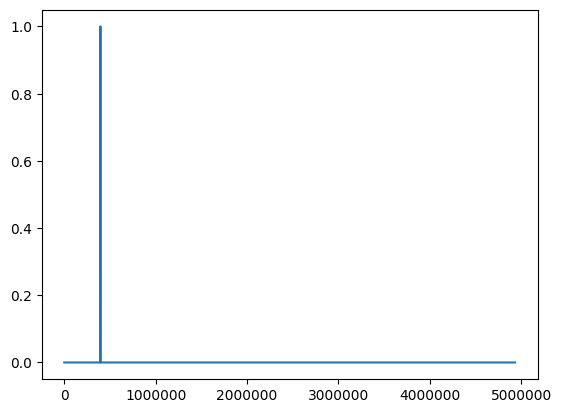

In [24]:
#=================================================================#
# BPF

function rect(t)
    N = length(t)
    x = zeros(N)
    for n = 1:N
        abs_t = abs(t[n])
        if abs_t > 0.5
            x[n] = 0.0
        elseif abs_t < 0.5
            x[n] = 1.0
        else
            x[n] = 0.5
        end
    end
    return x
end
    
δt = dt
δω = 2*pi/(N*dt)
    
ω = 0:δω:(N-1)*δω
f = ω/2*pi

ω0 = f0*2*pi

H = rect((ω.-ω0)/(2*pi*500))+rect((ω.-(ω0.- 2*pi/δt))/(2*pi*500))

figure()
plot(f,H);

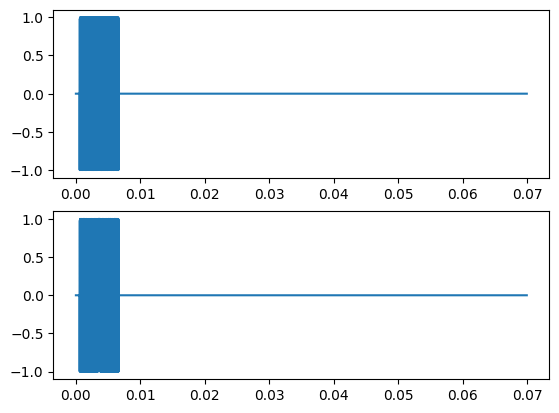

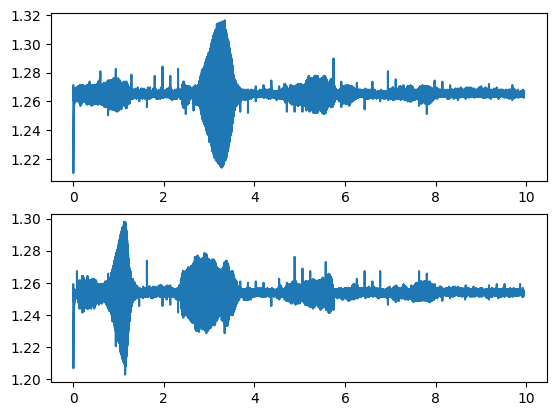

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe335da5f28>

In [25]:
#=================================================================
The signals
=================================================================#
#"expected echoes"
v_tx1 = v_tx
V_TX1 = fft(v_tx1);

v_tx2 = v_tx
V_TX2 = fft(v_tx2);

#plots
figure("Expected Echo")
title("Expected Echo")
subplot(2,1,1)
plot(t,v_tx1)
subplot(2,1,2)
plot(t,v_tx2) #query

# received echos
v_rx1 = MatchOne
V_RX1 = H.*(fft(v_rx1));

v_rx2 = MatchTwo
V_RX2 = H.*(fft(v_rx2));

#plots
figure("Unprocessed Received Echo")
title("Unprocessed Received Echo")
subplot(2,1,1)
plot(r[1:29000],v_rx1[1:29000])
subplot(2,1,2)
plot(r[1:29000],v_rx2[1:29000]) #query


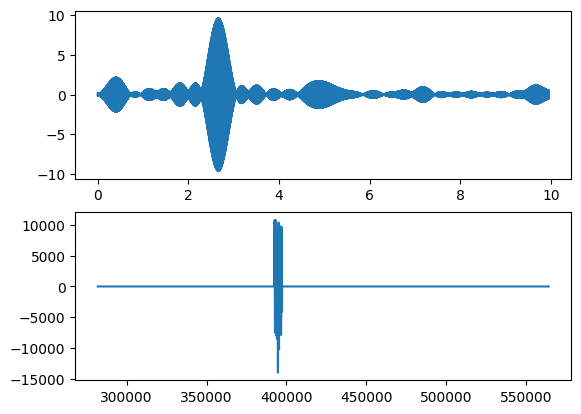

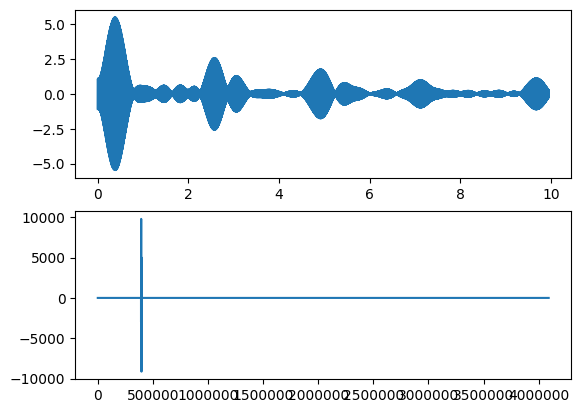

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe335be2358>

In [26]:
#=================================================================
Matched Filering
=================================================================#
#filter one
H1 = conj( V_TX1);

V_MF1 = H1.*V_RX1;
v_mf1 = ifft(V_MF1);

#plots
figure("First Echo match filtered")
title("First Echo match filtered")
subplot(2,1,1)
plot(r[1:29000],v_mf1[1:29000])
subplot(2,1,2)
plot(f[2000:4000],V_MF1[2000:4000]) #query

#Filter two
H2 = conj(V_TX2);

V_MF2 = H2.*V_RX2;
v_mf2 = ifft(V_MF2);

#plots
figure("second Echo match filtered")
title("second Echo match filtered")
subplot(2,1,1)
plot(r[1:29000],v_mf2[1:29000])
subplot(2,1,2)
plot(f[1:29000],V_MF2[1:29000]) #query

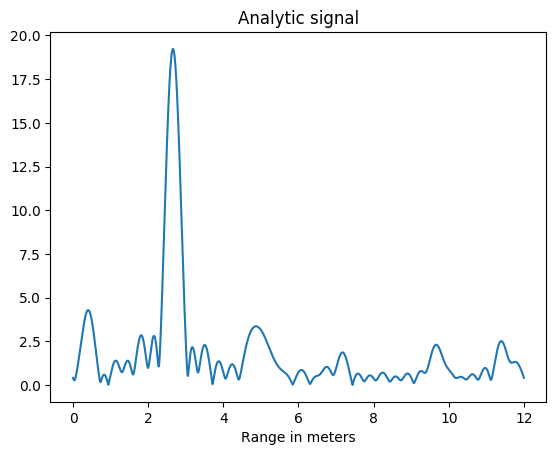

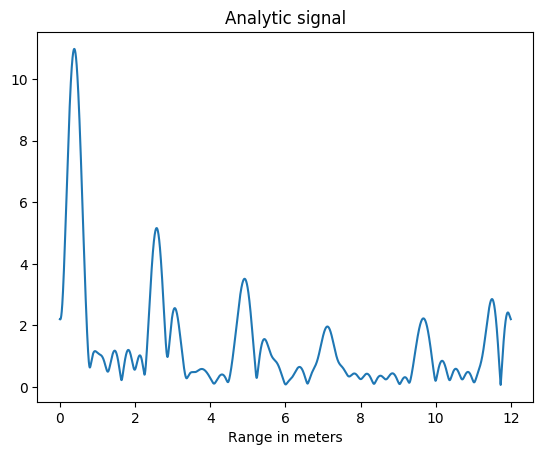

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe335a7e668>

In [27]:
#=================================================================
Analytic Signal
=================================================================#

V_ANAL1 = 2*V_MF1; # make a copy and double the values

if mod(N,2)==0 # case N even
    neg_freq_range = Int(N/2):N; # Define range of “neg-freq” components
else # case N odd
    neg_freq_range = Int((N+1)/2):N;
end

V_ANAL1[neg_freq_range] .= 0; # Zero out neg components in 2nd half of array.
v_anal1 = ifft(V_ANAL1);

#Analytic echo 2

V_ANAL2 = 2*V_MF2; # make a copy and double the values

if mod(N,2)==0 # case N even
    neg_freq_range = Int(N/2):N; # Define range of “neg-freq” components
else # case N odd
    neg_freq_range = Int((N+1)/2):N;
end

V_ANAL2[neg_freq_range] .= 0; # Zero out neg components in 2nd half of array.
v_anal2 = ifft(V_ANAL2);

figure()
title("Analytic signal")
xlabel("Range in meters")
plot(r,abs.(v_anal1))

figure()
title("Analytic signal")
xlabel("Range in meters")
plot(r,abs.(v_anal2))

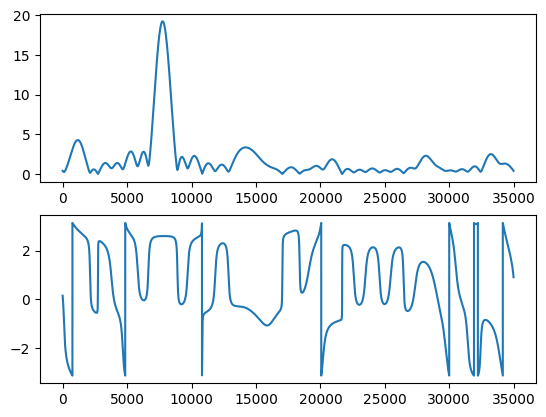

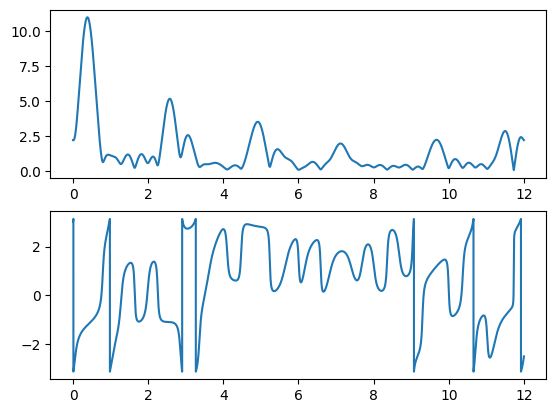

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe335382eb8>

In [40]:
#=================================================================
Base band Signals
=================================================================#
j=im;

v_bb1 = v_anal1.*exp.(-j*2*pi*f0.*t);
V_BB1 = fft(v_bb1);

v_bb2 = v_anal2.*exp.(-j*2*pi*f0.*t);
V_BB2 = fft(v_bb2);

g = figure()
title("Base band signal 2")
subplot(2,1,1)
plot(abs.(v_bb1))
subplot(2,1,2)
plot(angle.(v_bb1))

figure()
title("Base band signal 2")
subplot(2,1,1)
plot(r,abs.(v_bb2))
subplot(2,1,2)
plot(r,angle.(v_bb2)) 

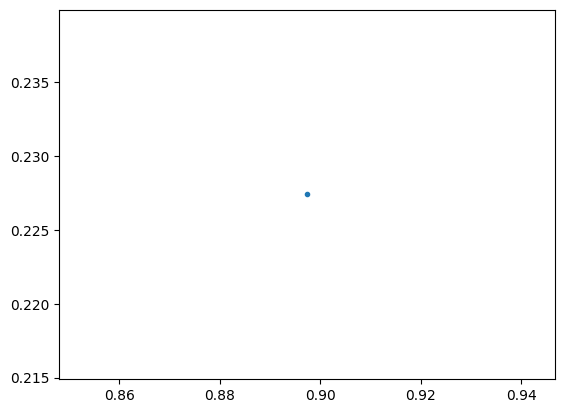

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fe335985e80>

In [39]:
d = 0.01778
k = 1
λ = c/f0

Δψ = angle.( v_bb2 .* conj(v_bb1))
θ = asin.((λ/(2*pi*d)).* (Δψ.+(k*2*pi)))

r_array = [r[2700],r]
θ_array = []

x = r[2700]*cos(θ[2700])
y = r[2700]*sin(θ[2700])

plot(x,y, ".")